In [1]:
import pandas as pd
import os
from astropy.time import Time

In [2]:
code_path = '/home/john/code/Astro/'
support_data_path = os.path.join(code_path, 'variable_star')
in_file = os.path.join(support_data_path, 'all_star_summary.csv')
const_file = os.path.join(support_data_path, 'constellation_names.txt')
const_target_file = os.path.join(support_data_path, 'constellation_names_targets.txt')
sequence_file = os.path.join(support_data_path,'baa_sequences.txt')
sequence_database_file = os.path.join(support_data_path,'baa_sequence_byclass.csv')

In [3]:
# get the constallation name abbreviations, to limit variable stars to sensible names
def load_const_pattern(filename):
    '''
    get the contellation names from text file
    so that only stars with a valid constellation name are returned
    '''
    f_const = open(filename)
    line = ' '
    const_abbr = []
    while line != '':
        line = f_const.readline()
        const_abbr.append(line.split('\t')[-1].replace('\n',''))
    const_abbr = const_abbr[2:]
    f_const.close()
    const_abbr_low = [ const.lower() for const in const_abbr ]
    pattern = '|'.join(const_abbr_low)
    pattern = pattern[:-1]

    return pattern

In [4]:
def load_seq_pattern():
    '''
    get the sequence files available on BAA and return as regexp pattern
    so that only stars for which there is a sequence file are returned.
    '''
    seq = pd.read_csv(sequence_file,delimiter='\t')
    obj = seq['Object Id']
    obj.describe()
    obs_lower = obj.str.lower()
    pattern = '|'.join(obs_lower)
    return pattern  

In [5]:
def load_baa_sequence_db():
    '''
    Load the BAA star summary data, containing sequence info, variable type, RA, dec, period etc.
    '''
    db = pd.read_csv(sequence_database_file)
    # clean nans in required fields
    db['Star'] = db['Star'].str.encode('ascii','ignore').str.decode('ascii')  #deal with non-ascii chars
    db['Con'] = db['Con'].str.encode('ascii','ignore').str.decode('ascii')  #deal with non-ascii chars
    db = db[db['Star']!='']  #empty cells
    db = db[db['Star'].isna()==False]
    db = db[db['Con'].isna()==False]
    db = db[db['Max'].isna()==False]
    db = db[db['Min'].isna()==False]    
    db = db[db['Chart'].isna()==False]  
    db['Star']=db['Star'].str.lower()
    db['Con']=db['Con'].str.lower()
    db['Full Name'] = db['Star'] + ' '+ db['Con']
    ra = db['RA'].str.split(expand=True)
    db['RA_hr'] = ra.iloc[:,0].astype('int')
    db['RA_min'] = ra.iloc[:,1].astype('int')
    dec = db['Dec'].str.split(expand=True)
    db['Dec_deg'] = dec.iloc[:,0].astype('float')
    db['Dec_min'] = dec.iloc[:,1].astype('float')
    return db

In [6]:
def load_baa_vsdb():
    # read in BAA variable star summary data as a Panda Data Frame
    vsdb = pd.read_csv(in_file)
    # rename to match the seq_db DataFrame
    vsdb = vsdb.rename(columns={'Variable Star':'Full Name'})
    vsdb['Full Name'] = vsdb['Full Name'].str.lower()
    # load the string matching patterns for constellations and BAA sequence files for filtering later.
    pattern = load_const_pattern(const_file)
    target_pattern = load_const_pattern(const_target_file)

    # get the JD portion of the first/last observation entries, and store as Astropy
    #  Time objects
    first_obs = vsdb['First Observation JD / UT'].str.split(expand=True)
    latest_obs = vsdb['Latest Observation JD / UT'].str.split(expand=True)
    vsdb['First JD'] = Time(first_obs.iloc[:,0].tolist(), format='jd')
    vsdb['Latest JD'] = Time(latest_obs.iloc[:,0].tolist(), format='jd')
    vsdb.head()
    return (vsdb, pattern, target_pattern)

In [7]:
seq_db = load_baa_sequence_db()
seq_db.head()

,Star,Con,RA,Dec,Type,Max,Min,Period,Chart,Class,Eclipse Duration,Full Name,RA_hr,RA_min,Dec_deg,Dec_min
0,r,and,00 24,+38 35,M,5.8,15.2,409.2,53.02,pulsating,NaN,r and,0,24,38.0,35.0
1,w,and,02 18,+44 18,M,6.7,14.6,397.3,35.02,pulsating,NaN,w and,2,18,44.0,18.0
2,aq,and,00 28,+35 35,SRb,7.7,9.5,169,303.01,pulsating,NaN,aq and,0,28,35.0,35.0
3,bz,and,00 38,+45 36,Lb,7.7,8.6,NaN,304.01,pulsating,NaN,bz and,0,38,45.0,36.0
4,rs,and,23 55,+48 38,SRa,7,9.4,136,334.01,pulsating,NaN,rs and,23,55,48.0,38.0


In [8]:
# Load database
(vsdb_full, const_pattern, const_target_pattern) = load_baa_vsdb()
# Database filtering
# VALID CONSTELLATION: where the Variable Star column has where there are two fields in the name (e.g. 'TX Dra')
#     and the VS Constellation column matches a valid constellation
vsdb_allconst = vsdb_full
vsdb_allconst['Valid_nFields'] = vsdb_allconst['Full Name'].str.count(' ')

#remove rows which don't have 1 nFields
vsdb_allconst.drop(vsdb_allconst[vsdb_allconst.Valid_nFields != 1].index, inplace=True)

# set the second field to be a 'Constellation' description.  Needs to be lower case to match pattern, above.
vs_const = vsdb_allconst['Full Name'].str.split(expand=True)
vsdb_allconst['VS Constellation'] = vs_const[1].str.lower()

# check whether str.contains is working...
vsdb_allconst['VS Constellation'].str.contains(const_pattern)==True

# drop all rows where the str.contains() conditional statement 
vsdb_allconst.drop(vsdb_allconst[vsdb_allconst['VS Constellation'].str.contains(const_pattern)==False].index, inplace=True)
vsdb_allconst.describe()

,Number of Observations,Number of Observers,Maximum Magnitude,Minimum Magnitude,Range,Valid_nFields
count,2157.000000,2157.000000,2157.000000,2157.000000,2157.000000,2157.0
mean,1021.777932,10.982383,9.598873,11.771966,2.173092,1.0
std,3361.628004,27.893377,2.901859,3.405555,2.368961,0.0
min,1.000000,1.000000,-0.600000,1.800000,0.000000,1.0
25%,2.000000,1.000000,7.400000,9.100000,0.100000,1.0
50%,21.000000,1.000000,9.900000,11.400000,1.400000,1.0
75%,363.000000,5.000000,11.500000,14.500000,3.480000,1.0
max,59231.000000,302.000000,18.900000,21.000000,17.200000,1.0


In [9]:
# Next, cross-reference against stars which exist in the VSS sequence lists
# this checks whether each Variable Star in vsdb is present in seq_db
# majority AREN'T in the sequence lists (seq_db)
vsdb_allconst['Full Name'].isin(seq_db['Full Name']).value_counts()

False    1739
True      418
Name: Full Name, dtype: int64

In [10]:
#  Remarkable bit of pandas.  Merging two Data Frame based on the name of the star
merged_db = pd.merge(vsdb_allconst, seq_db, how='left', on='Full Name')

# clean duplicate and unwanted info
#merged_db.drop(['Star', 'Con', 'Max', 'Min', 'First Observation JD / UT'])
merged_db = merged_db.drop(columns=['Star', 'Con', 'Max', 'Min', 'First Observation JD / UT', 'Valid_nFields'])
merged_db.columns

Index(['Full Name', 'Number of Observations', 'Number of Observers',
       'Latest Observation JD / UT', 'Maximum Magnitude', 'Minimum Magnitude',
       'Range', 'First JD', 'Latest JD', 'VS Constellation', 'RA', 'Dec',
       'Type', 'Period', 'Chart', 'Class', 'Eclipse Duration', 'RA_hr',
       'RA_min', 'Dec_deg', 'Dec_min'],
      dtype='object')

In [11]:
with pd.option_context('display.max_rows',10):
    print(merged_db[merged_db['VS Constellation']=='aur'][['Full Name','Number of Observations','Chart']])

     Full Name  Number of Observations   Chart
8       aa aur                      13     NaN
11      ab aur                   10630  301.01
16      ac aur                       1     NaN
21      ad aur                       2     NaN
27      ae aur                    3782     NaN
...        ...                     ...     ...
2018    wx aur                       1     NaN
2042     x aur                    7775   AAVSO
2078    xy aur                       1     NaN
2126     z aur                       3     NaN
2151  zeta aur                     226     NaN

[81 rows x 3 columns]


In [12]:
# SEQUENCE FILE EXISTS
# next, filter on the VS which are available as a sequence file from the BAA
vsdb_target = merged_db[merged_db['Chart'].notna()]
vsdb_target.head()
vsdb_target.describe()
vsdb_target['Class'].value_counts()

pulsating      192
cataclysmic    158
eclipsing       68
Name: Class, dtype: int64

In [13]:
# start filtering on conditions
# ignore eclipsing binaries
vsdb_target = vsdb_target[vsdb_target['Class']!='eclipsing']
vsdb_target['Class'].value_counts()

pulsating      192
cataclysmic    158
Name: Class, dtype: int64

In [14]:
# filtering conditions on min magnitude (always visible with binoculars) and range (for SNR)
# based on the numbers in the output below.  
# range has 75% of values > v1.3, so not too significant on the number of targets
# min magnutude has only 25% of values >9.0, so more significant 

# first, range > v1.0
# this reduces the number of objects from ~915 to ~750
vsdb_target = vsdb_target[vsdb_target['Range']>=1.0]
vsdb_target.describe()

,Number of Observations,Number of Observers,Maximum Magnitude,Minimum Magnitude,Range,RA_hr,RA_min,Dec_deg,Dec_min
count,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,343.000000,342.000000
mean,5223.629738,49.746356,8.409708,13.016443,4.606735,12.443149,31.323615,32.224606,30.400585
std,6812.999739,50.239279,2.818663,3.777003,2.350244,6.962019,17.472039,23.273604,17.016476
min,9.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,-23.000000,0.000000
25%,1264.500000,10.000000,6.400000,9.100000,2.525000,6.000000,16.000000,17.000000,17.000000
50%,2759.000000,33.000000,7.800000,13.900000,4.400000,14.000000,31.000000,32.000000,30.000000
75%,6773.000000,73.000000,10.650000,16.250000,6.175000,19.000000,47.000000,51.000000,46.000000
max,59231.000000,302.000000,14.300000,20.800000,17.200000,23.000000,59.000000,85.000000,59.000000


In [15]:
# filter on min magnitude to find suitable binocular targets
#  reduces targets to ~200
vsdb_target = vsdb_target[vsdb_target['Minimum Magnitude']<=9.0]
vsdb_target.describe()

,Number of Observations,Number of Observers,Maximum Magnitude,Minimum Magnitude,Range,RA_hr,RA_min,Dec_deg,Dec_min
count,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,5779.150000,73.25000,5.725625,7.964000,2.238375,11.412500,32.587500,32.850000,31.012500
std,5409.093598,50.06186,1.211624,1.002692,0.861886,7.074099,18.309362,25.859944,17.306247
min,9.000000,1.00000,1.000000,3.000000,1.000000,0.000000,1.000000,-13.000000,0.000000
25%,2156.000000,35.50000,5.200000,7.575000,1.800000,5.000000,15.500000,17.000000,19.000000
50%,4385.000000,68.50000,6.000000,8.300000,2.120000,12.000000,35.500000,35.500000,29.000000
75%,7573.500000,100.25000,6.500000,8.600000,2.600000,18.000000,49.000000,55.000000,46.250000
max,29928.000000,237.00000,7.700000,9.000000,7.900000,23.000000,59.000000,85.000000,59.000000


array([[<AxesSubplot: title={'center': 'Number of Observations'}>]],
      dtype=object)

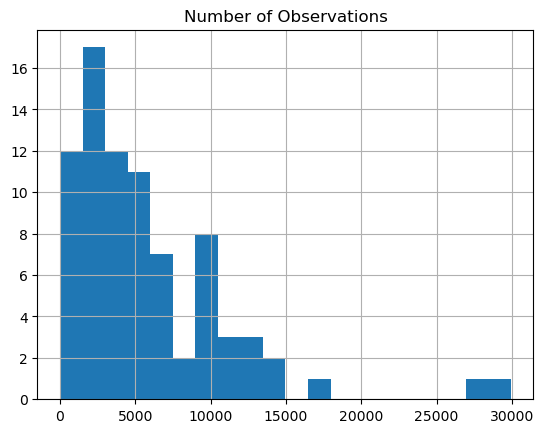

In [16]:
vsdb_target.hist('Number of Observations', bins=20)

In [20]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
vsdb_target.sort_values(by='RA_hr', ascending=True)

,Full Name,Number of Observations,Number of Observers,Latest Observation JD / UT,Maximum Magnitude,Minimum Magnitude,Range,First JD,Latest JD,VS Constellation,...,Dec,Type,Period,Chart,Class,Eclipse Duration,RA_hr,RA_min,Dec_deg,Dec_min
469,gamma cas,16678,142,2459904.271000 20 Nov 2022 18:30:14.400000,1.50,3.00,1.50,2433650.3125,2459904.271,cas,...,+60 43,GCAS,NaN,64.01,cataclysmic,NaN,0.0,57.0,60.0,43.0
1234,tv psc,1791,33,2459906.500000 23 Nov 2022 00:00:00.000000,4.54,5.90,1.36,2439844.3,2459906.5,psc,...,+17 54,SR,49.1,1972Sep09,pulsating,NaN,0.0,28.0,17.0,54.0
2035,wz cas,7671,99,2459904.274000 20 Nov 2022 18:34:33.600000,6.30,8.80,2.50,2440285.351,2459904.274,cas,...,+60 21,SRb,186,323.01,pulsating,NaN,0.0,1.0,60.0,21.0
1714,v465 cas,14904,135,2459904.271000 20 Nov 2022 18:30:14.400000,4.60,8.60,4.00,2440487.615,2459904.271,cas,...,+57 48,SRb,60,233.02,pulsating,NaN,1.0,18.0,57.0,48.0
2142,z psc,2259,45,2459906.507000 23 Nov 2022 00:10:04.800000,6.30,8.30,2.00,2440244.461,2459906.507,psc,...,+25 46,SRb,155.8,278.01,pulsating,NaN,1.0,16.0,25.0,46.0
1874,v770 cas,1446,13,2459904.274000 20 Nov 2022 18:34:33.600000,7.20,8.70,1.50,2447465.471,2459904.274,cas,...,+60 54,Lb,NaN,AAVSO,pulsating,NaN,1.0,40.0,60.0,54.0
1637,v393 cas,4034,33,2459904.274000 20 Nov 2022 18:34:33.600000,6.95,8.40,1.45,2440711.389,2459904.274,cas,...,+71 18,SRa,393,337.01,pulsating,NaN,2.0,3.0,71.0,18.0
607,kk per,2024,54,2459908.260000 24 Nov 2022 18:14:24.000000,7.00,9.00,2.00,2440689.4,2459908.26,per,...,+56 34,Lc,NaN,344.01,pulsating,NaN,2.0,10.0,56.0,34.0
2136,z eri,121,3,2459858.485000 5 Oct 2022 23:38:24.000000,6.40,8.10,1.70,2444572.459,2459858.485,eri,...,-12 27,SRb,74,AAVSO,pulsating,NaN,2.0,47.0,-12.0,27.0
1062,ss cep,5420,81,2459904.278000 20 Nov 2022 18:40:19.200000,6.20,8.60,2.40,2439854.3,2459904.278,cep,...,+80 19,SRb,90,315.01,pulsating,NaN,3.0,50.0,80.0,19.0
